# 프로젝트 : 네이버 영화리뷰 감성분석

## 1. 데이터 준비와 확인
### - ratings_train.txt 과 ratings_test.txt 다운로드 받고 준비!!


In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3 모델구성을 위한 데이터 분석 및 가공

### - 데이터셋 내 문장 길이 분포, 적절한 최대 문장 길이 지정

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### - keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


#### post 경우 마지막 입력값에 채워지고 pre 경우 앞쪽에 입력값이 채워져 좀 더 효율적이다.

## 4. 모델구성 및 validation set 구성(3가지이상)

#### - RNN 모델

In [7]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


#### - 1D CNN

In [8]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.MaxPooling1D(5))
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

#model.summary()

#### - GlobalMaxPooling1D()

In [9]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

#model.summary()

In [10]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 5. 모델 훈련 개시

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 6ms/step - loss: 0.5286 - accuracy: 0.7571 - val_loss: 0.3980 - val_accuracy: 0.8473
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3572 - accuracy: 0.8525 - val_loss: 0.3485 - val_accuracy: 0.8504
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3233 - accuracy: 0.8664 - val_loss: 0.3411 - val_accuracy: 0.8512
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3090 - accuracy: 0.8729 - val_loss: 0.3404 - val_accuracy: 0.8526
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2974 - accuracy: 0.8780 - val_loss: 0.3421 - val_accuracy: 0.8523
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2862 - accuracy: 0.8820 - val_loss: 0.3386 - val_accuracy: 0.8548
Epoch 7/10
266/266 [==============================] - 1s 6ms/step - loss: 0.2743 - accuracy: 0.8871 - val_loss: 0.3456 - val_accuracy: 0.8523
Epoch 

In [12]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results) #테스트셋 평가

1537/1537 - 2s - loss: 0.3770 - accuracy: 0.8473
[0.37695953249931335, 0.8472648859024048]


## 6. Loss, Accuracy 그래프 시각화

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


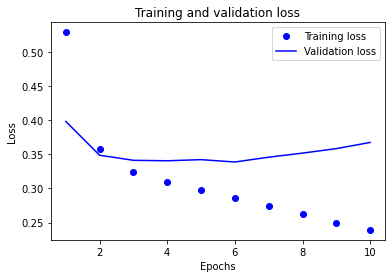

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() #그래프 시각화

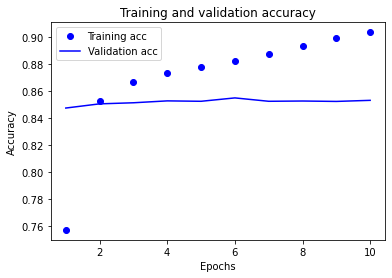

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 

## 7. 학습된 Embedding 레이어 분석

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [17]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['강아지']
vector

array([ 0.02809257,  0.00951336,  0.03545163,  0.155254  ,  0.00616082,
       -0.0403896 , -0.01901854,  0.04078928, -0.01820729,  0.06833577,
       -0.00446101,  0.05134029, -0.03200015,  0.03676918, -0.00690734,
       -0.03148751], dtype=float32)

In [19]:
word_vectors.similar_by_word("강아지")

[('네요', 0.877557635307312),
 ('대상', 0.8686639070510864),
 ('쯤', 0.8453407287597656),
 ('헌터', 0.841800332069397),
 ('수능', 0.8394447565078735),
 ('싶', 0.8358801603317261),
 ('드', 0.8339107632637024),
 ('........', 0.8287228345870972),
 ('드라마', 0.828015923500061),
 ('여고생', 0.8255923390388489)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [20]:
#from gensim.models import KeyedVectors
#word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
#vector = word2vec['computer']
#vector     # 무려 300dim의 워드 벡터입니다.

In [29]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)
a = ko_model.wv.most_similar("강아지")

In [30]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
ko_model.similar_by_word("강아지")

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('고양이', 0.7290453314781189),
 ('거위', 0.7185634970664978),
 ('토끼', 0.7056223750114441),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.693433403968811),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.675035297870636),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512461304664612)]

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [32]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
#model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.LSTM(20))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                17680     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,017,857
Trainable params: 2,017,857
Non-trainable params: 0
_________________________________________________________________


In [33]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 7s 26ms/step - loss: 0.5117 - accuracy: 0.7485 - val_loss: 0.3826 - val_accuracy: 0.8331
Epoch 2/5
266/266 [==============================] - 7s 25ms/step - loss: 0.3536 - accuracy: 0.8485 - val_loss: 0.3398 - val_accuracy: 0.8543
Epoch 3/5
266/266 [==============================] - 7s 25ms/step - loss: 0.3108 - accuracy: 0.8701 - val_loss: 0.3502 - val_accuracy: 0.8454
Epoch 4/5
266/266 [==============================] - 7s 25ms/step - loss: 0.2866 - accuracy: 0.8829 - val_loss: 0.3295 - val_accuracy: 0.8596
Epoch 5/5
266/266 [==============================] - 6s 24ms/step - loss: 0.2691 - accuracy: 0.8908 - val_loss: 0.3290 - val_accuracy: 0.8607


In [34]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3457 - accuracy: 0.8538
[0.34565606713294983, 0.8538153171539307]


## 프로젝트를 마치며...

### 첫번째 Model (keras.layers.GlobalMaxPooling1D()) 로 epochs=10 하였을때 79%정확도가 나와 epochs=5 으로 변경해보니 accuracy: 0.7929 크게 변동이 없었다.  두번째로 Model 1D CNN 로 변경하여 epochs=10 하였을때 accuracy: 0.8116 나와 epochs=5 으로  accuracy: 0.8116 크게 변동이 없었다. 마지막으로 RNN모델로 변경하여 epochs=10 하였을때 accuracy: 0.8490 나와 epochs=5 변경하여 accuracy: 0.8446 나왔고 조금더 해보면 될것같아  LSTM(20)으로 변경하여 accuracy: 0.8538 상승 시켰다.

### 이번 프로젝트는 수정해야할 코드들이 구석 구석 있었고 에러들이 나올때마다 조원들과 협동하여 해결 했으며 모델들을 조금 더 자세히 뜯어보고 인공지능분야에 대해 전체적인 흐름을 더 이해하게 해준 것같다. 
